In [1]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from normalize import *
from pca_plots import *
from test_model import test_abundance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata: ad.AnnData = ad.read_h5ad(CT_COUNTS_META_PATH)

ROSMAP_data = ROSMAP_data.convert_dtypes()
ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

In [2]:
# Remove outliers

from outliers import *

calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', column_name='RELN_metric')
thresh = np.percentile(ct_counts_metadata.obs['RELN_metric'], 97)
ct_counts_metadata = remove_outliers(ct_counts_metadata, 'RELN_metric', thresh)

/home/jacob/Documents/BEP/bsc-thesis-scripts/outliers.py:38: RuntimeWarning: invalid value encountered in scalar divide
  cpm = ct_count / avg_metric
/home/jacob/Documents/BEP/bsc-thesis-scripts/outliers.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  cpm = ct_count / avg_metric


/home/jacob/Documents/BEP/bsc-thesis-scripts/normalize.py:15: ImplicitModificationWarning: Setting element `.layers['norm_l1']` of view, initializing view as actual.
  adata.layers[layer_name] = adata.X.copy()


54 54
54 54
54 54


/home/jacob/Documents/BEP/bsc-thesis-scripts/pca_plots.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


54 54


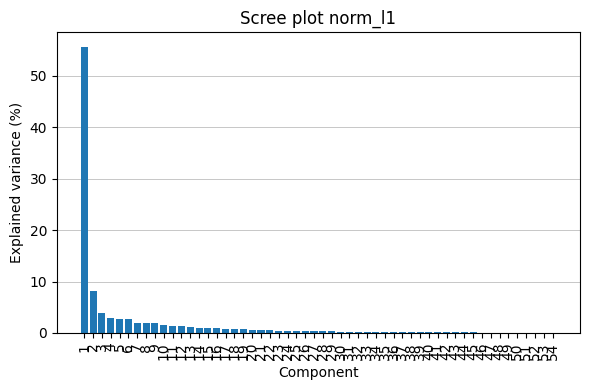

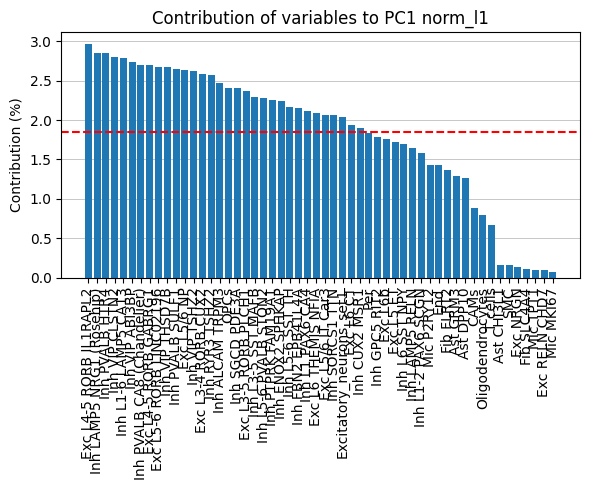

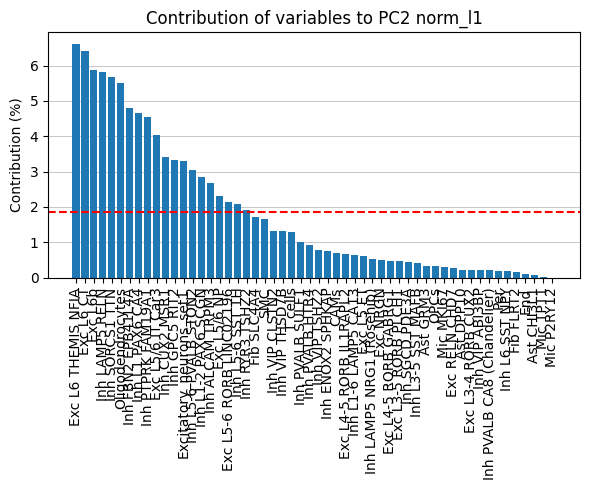

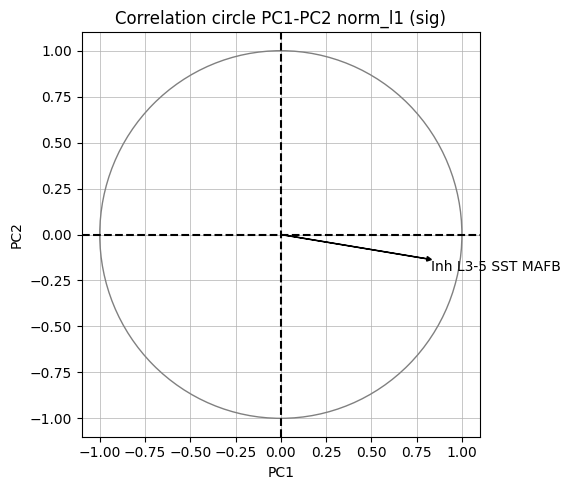

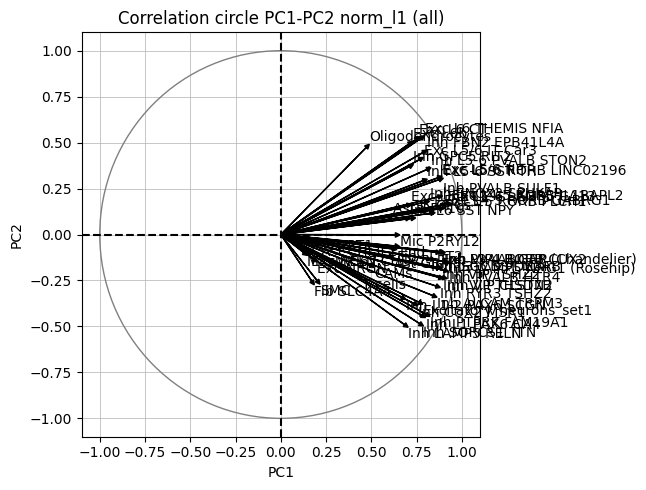

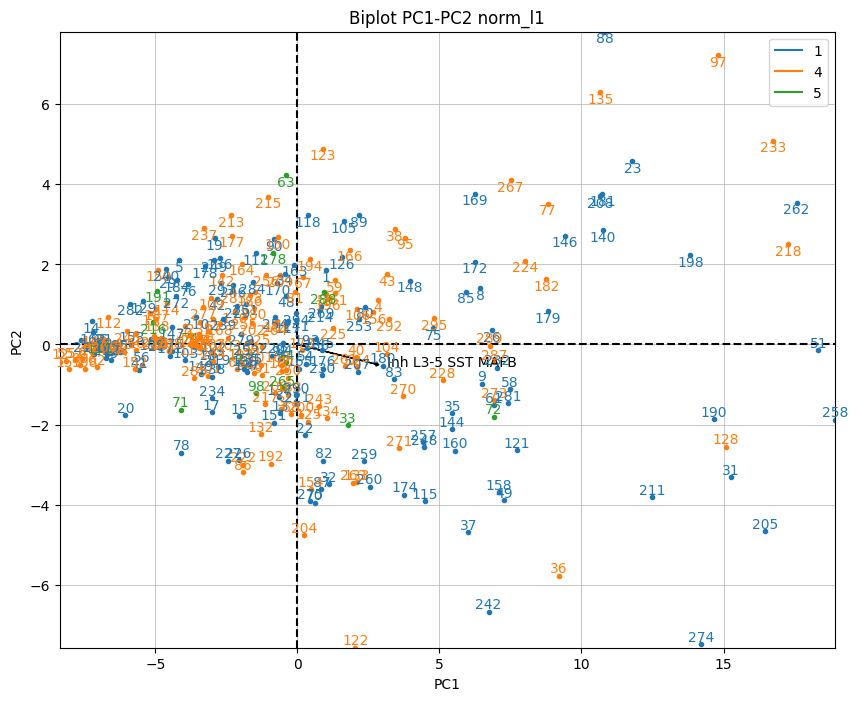

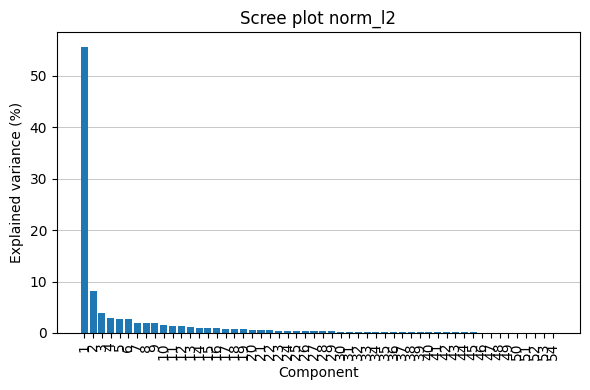

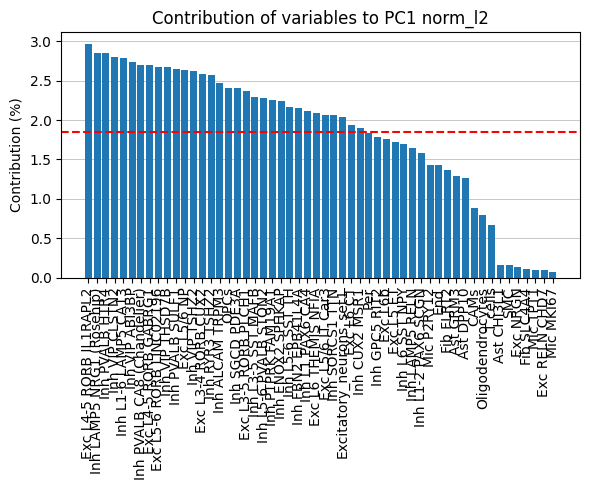

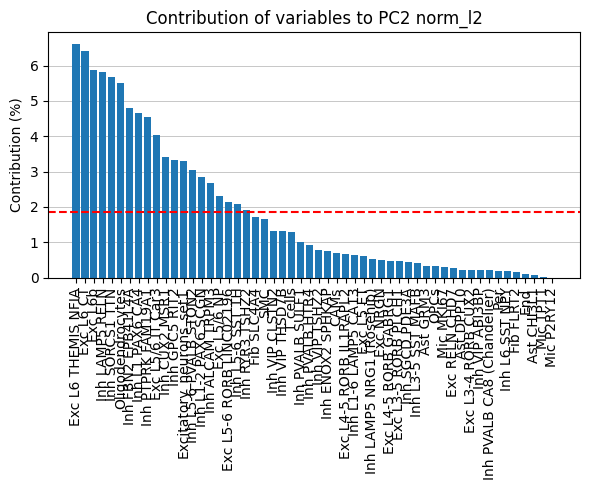

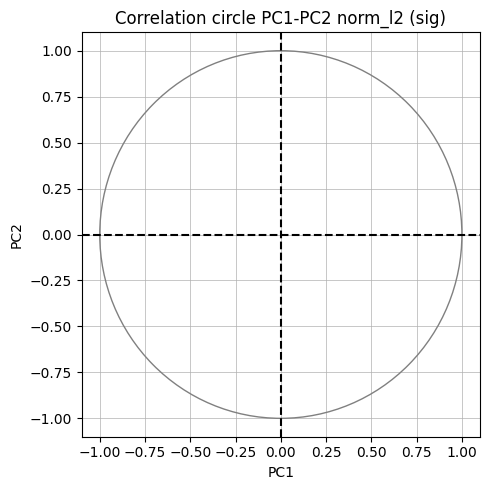

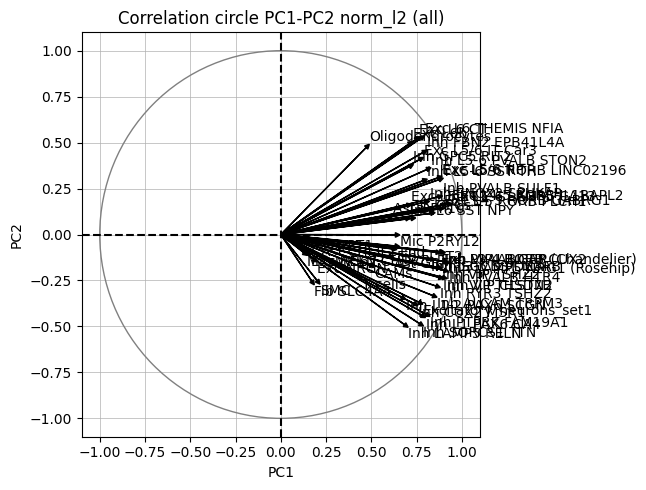

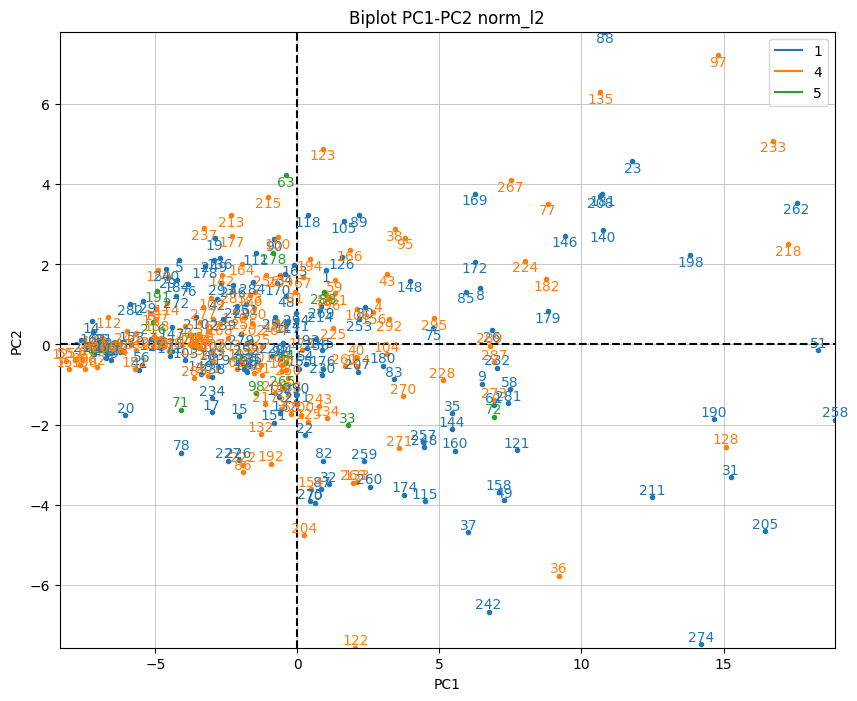

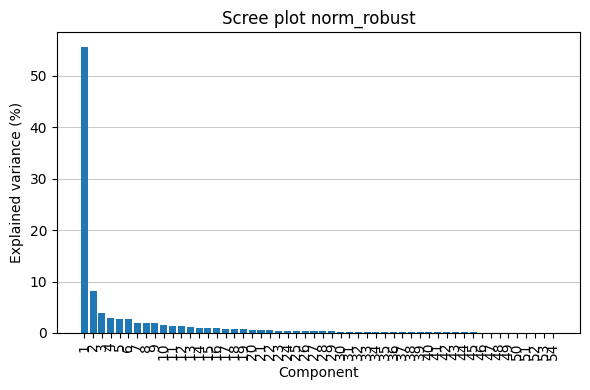

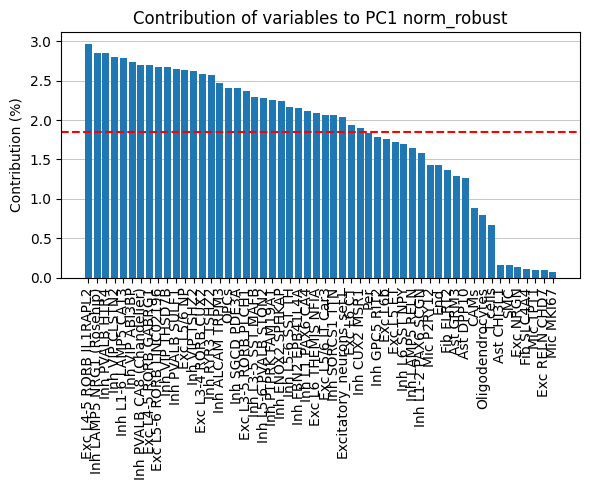

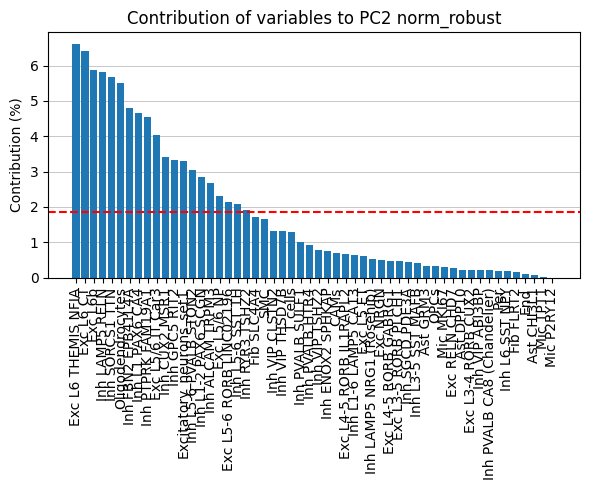

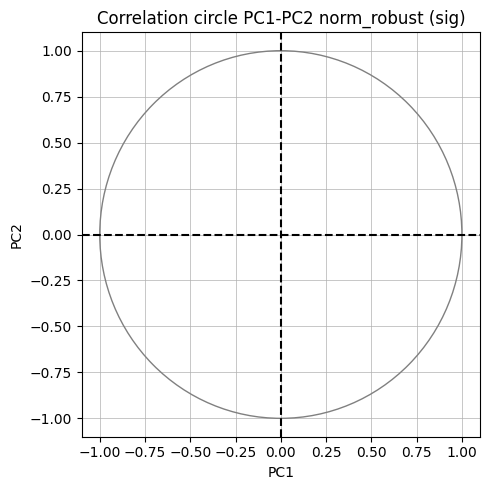

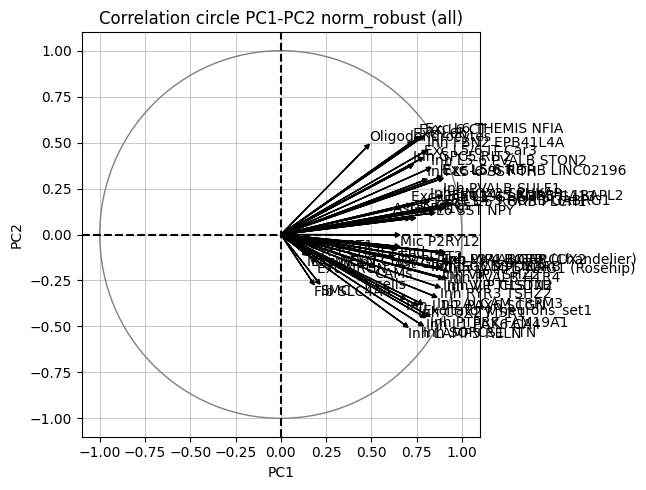

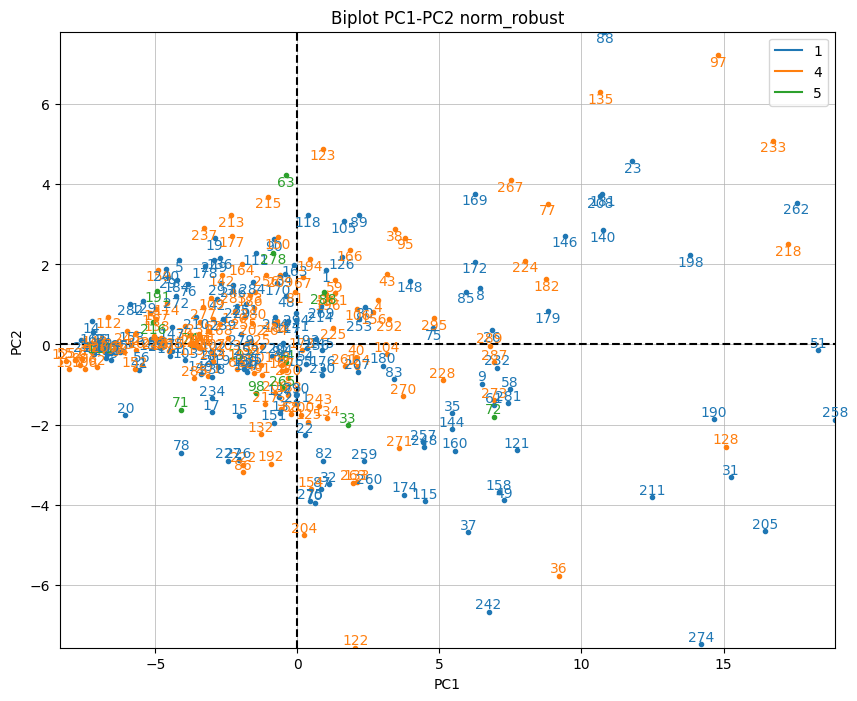

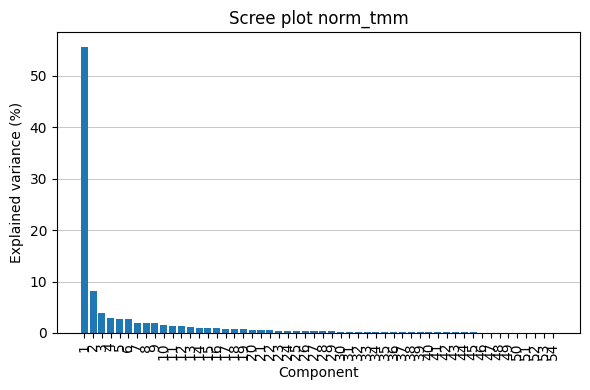

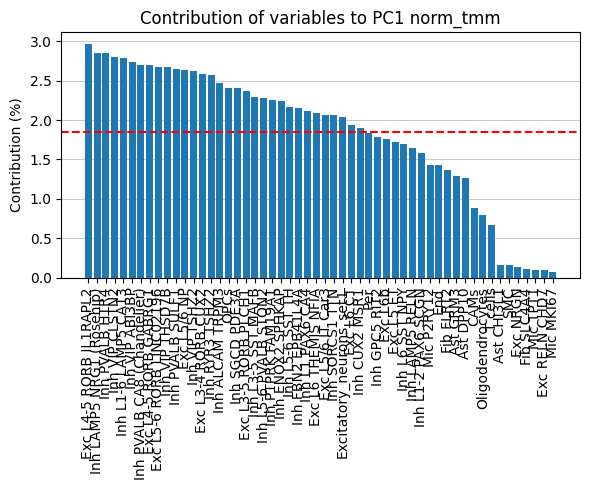

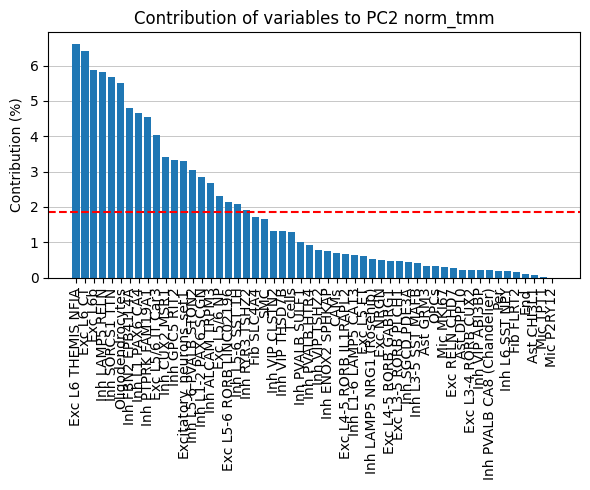

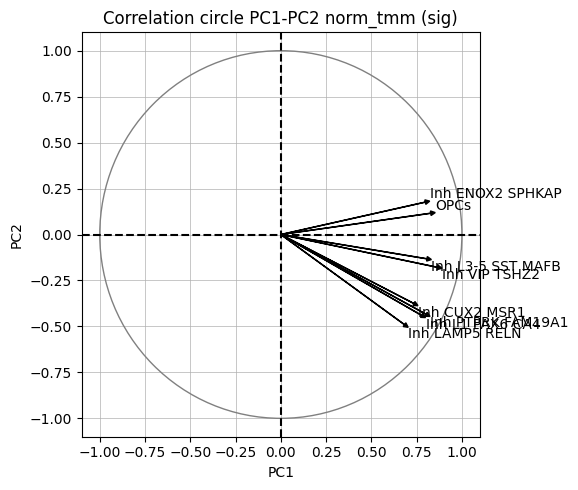

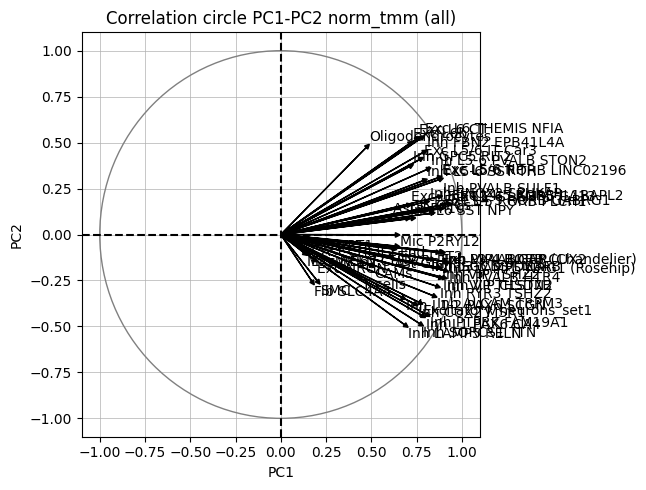

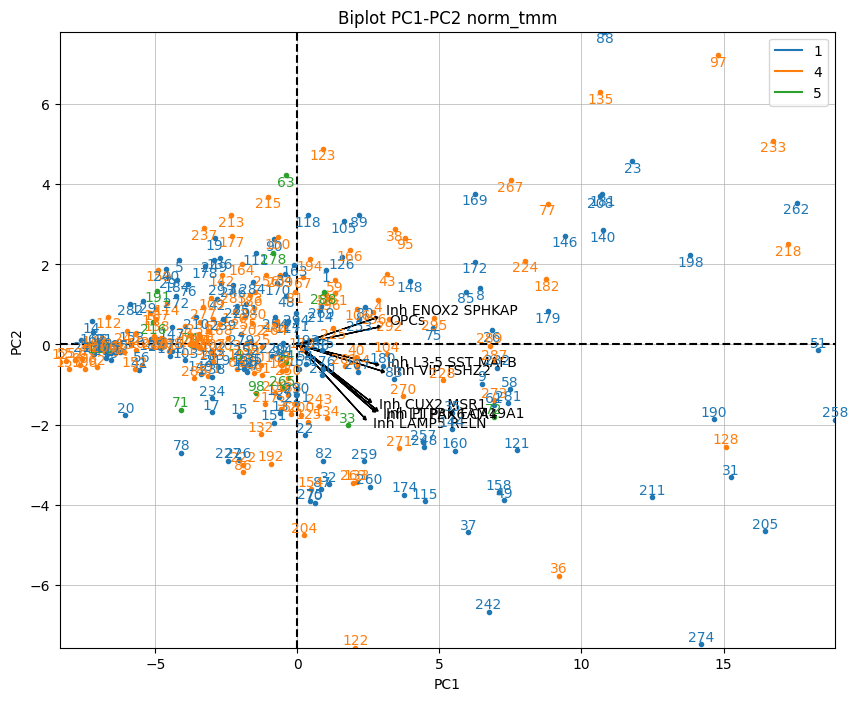

In [3]:
normalizations: list[tuple] = [(normalize_l1, 'norm_l1'), 
                               (normalize_l2, 'norm_l2'),
                               (normalize_robust, 'norm_robust'), 
                               (normalize_tmm, 'norm_tmm')]

col_labels = ct_counts_metadata.var_names
AD_filter = (ct_counts_metadata.obs['cogdx'] == 1) | (ct_counts_metadata.obs['cogdx'] == 4) | (ct_counts_metadata.obs['cogdx'] == 5)
X_base = ct_counts_metadata.X[AD_filter]
model = PCA().fit(X_base)

for func, layer in normalizations:
    # X is the scaled normalized value of adata.X
    func(ct_counts_metadata, layer)  # Normalization/scaling
    test_abundance(ct_counts_metadata, norm_layer=layer)
    X = StandardScaler().fit_transform(X_base)
    model = PCA().fit(X)

    vec_filter = ct_counts_metadata.var['significant'].tolist()
    pca_screeplot(model, (6, 4), layer)
    pca_contribplot(model, col_labels, comp=0, title_add=layer)
    pca_contribplot(model, col_labels, comp=1, title_add=layer)
    pca_corplot(model, col_labels, comp = [0,1], title_add=layer + ' (sig)', vec_filter=ct_counts_metadata.var['significant'].tolist())
    pca_corplot(model, col_labels, comp = [0,1], title_add=layer + ' (all)')
    print(len(model.components_), len(ct_counts_metadata.var.index))
    pca_biplot(X, model, ct_counts_metadata.var.index, [0, 1], ct_counts_metadata.obs['cogdx'][AD_filter].tolist(), title_add=layer, vec_filter=vec_filter)